<a href="https://colab.research.google.com/github/BohdanLiuisk/neural-networks/blob/main/hybrid_sn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive')

hsi_datasets_path = '/content/drive/My Drive/hsi_datasets'
hsi_datasets_local_path = '/content/dataset'
shutil.copytree(hsi_datasets_path, hsi_datasets_local_path)

print("Current working directory:", os.getcwd())
print("Files in the working directory:")
os.listdir('.')

Mounted at /content/drive
Current working directory: /content
Files in the working directory:


['.config', 'models', 'drive', 'dataset', 'sample_data']

1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


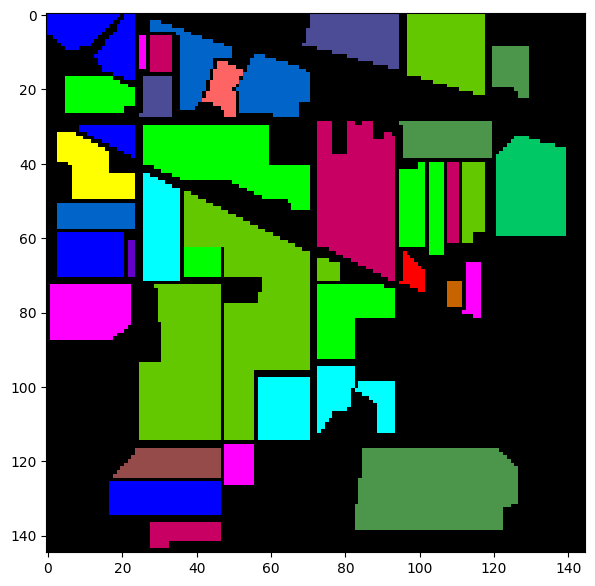

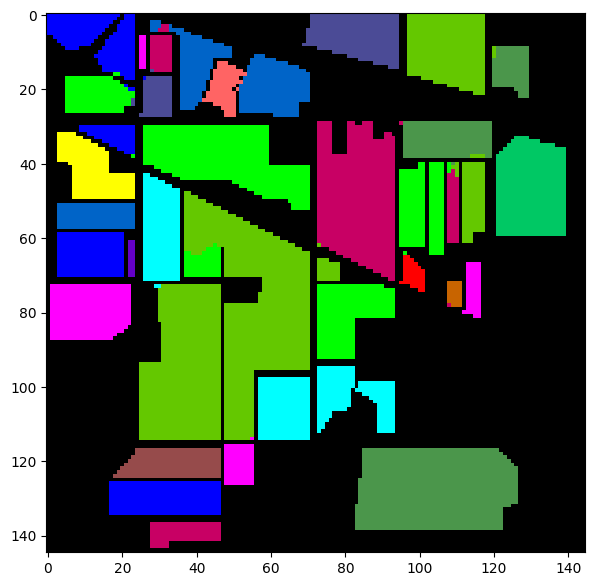

In [3]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv3D, Conv2D, Dense, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from keras.utils import np_utils
import spectral
from matplotlib import colors

spectral.settings.WX_GL_DEPTH_SIZE = 16

DATASET = 'IP'
DATA_PATH = '/content/dataset/'
MODEL_PATH = '/content/drive/MyDrive/trained_models/hybrid_sn.h5'
WINDOW_SIZE = 25
TEST_RATIO = 0.7

def load_data(name):
    if name == 'IP':
        data = sio.loadmat(os.path.join(DATA_PATH, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(DATA_PATH, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(DATA_PATH, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(DATA_PATH, 'PaviaU_gt.mat'))['paviaU_gt']
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
  
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca
  
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
  
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

X, y = load_data(DATASET)
X.shape, y.shape
K = 30 if DATASET == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)
K = X.shape[2]
X, y = createImageCubes(X, y, windowSize=WINDOW_SIZE)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, TEST_RATIO)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape
Xtrain = Xtrain.reshape(-1, WINDOW_SIZE, WINDOW_SIZE, K, 1)
ytrain = np_utils.to_categorical(ytrain)
S = WINDOW_SIZE
L = K
output_units = 9 if (DATASET == 'PU' or DATASET == 'PC') else 16
model = load_model(MODEL_PATH)
adam = tf.keras.optimizers.legacy.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
Xtest = Xtest.reshape(-1, WINDOW_SIZE, WINDOW_SIZE, K, 1)
ytest = np_utils.to_categorical(ytest)
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

# load the original image
X, y = load_data(DATASET)
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = WINDOW_SIZE
numComponents = K
X,pca = applyPCA(X, numComponents=numComponents)
X = padWithZeros(X, PATCH_SIZE//2)
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))